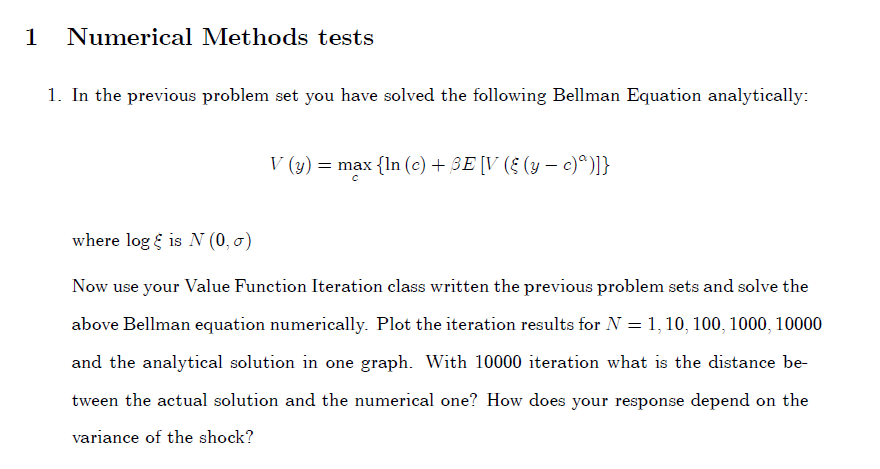

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange,jit
from scipy.optimize import fsolve, fminbound
from scipy import interp
import time

In [2]:
def σ_star(y, α=0.4, β=0.96):
    """
    True optimal policy
    """
    return (1 - α * β) * y

def v_star(y, α=0.4, β=0.96, μ=0):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [3]:
α = 0.4  # Production function parameter

@njit
def h(y,u):
    """
    Cobb-Douglas production function
    """
    return (y-u)**α

@njit
def r(y,u,sigma=0.1):
    return np.log(u)


@njit
def Gamma(y):
    return y


In [4]:
class VFI:
    def __init__(self,
                 h,  # Production function (can have other implementations too)
                 r,# return function
                 Gamma,
                 β=0.96,           # Discount factor
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=150,
                 shock_size=250):
        np.random.seed(10)
        self.β, self.μ, self.s = β, μ, s
        self.h, self.r = h, r
        self.grid_size=grid_size
        
        self.grid = np.linspace(1e-5, grid_max, grid_size)         # Set up grid: 2 dimensional because we have a,s
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks

    #@njit
    def T(self, w):
        grid, grid_size, shocks= self.grid, self.grid_size, self.shocks
        β=self.β 
        h,r=self.h, self.r 
        
        # === Apply linear interpolation to w === #
        Iw = lambda x: interp(x, grid, w)

        Tw = np.empty(grid_size)
        u_opt = np.empty(grid_size) #maximize on u

        for i, y in enumerate(grid):
            #objective: U(c)+βV(f(k))
            objective = lambda u: - r(y,u) - β * np.mean(Iw(h(y,u) * shocks)) 
            u_star = fminbound(objective, 1e-6, Gamma(y))
            u_opt[i]=u_star
            Tw[i] = - objective(u_star) #objective is -log(c) - beta*Aw(k**alpha - c)
        return Tw,u_opt
    
    #@njit
    def solve_model(self,tol=1e-4,
                max_iter=1000):
        
        grid= self.grid

        # Set up loop
        v = 5 * np.log(grid) #initial condition
        i = 0
        error = tol + 1

        while i < max_iter and error > tol:
            v_new,c_new = self.T(v)
            error = np.max(np.abs(v - v_new))
            i += 1
            v = v_new

        if i == max_iter:
            print("Failed to converge!")

        if i < max_iter:
            print(f"\nConverged in {i} iterations.")

        return v_new,c_new,error


Converged in 227 iterations.


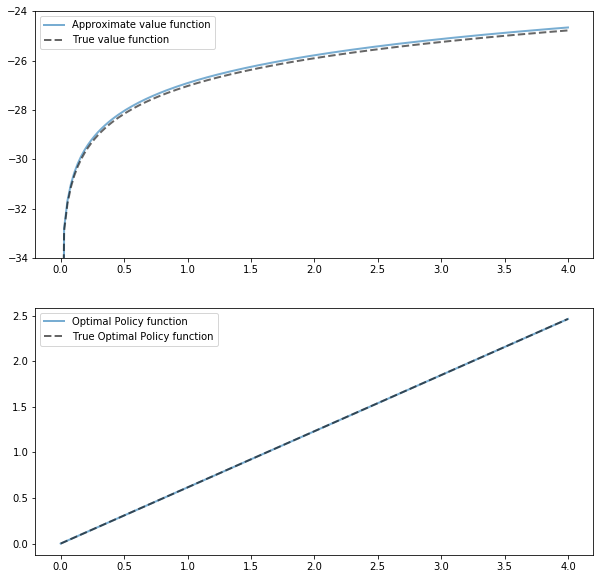

elapsed time: 24.437012910842896


In [19]:
start = time.time()

vfi=VFI(h,r,Gamma)

v_solution,c_solution,error=vfi.solve_model()
fig, axes = plt.subplots(2,1,figsize=(10, 10))

axes[0].plot(vfi.grid, v_solution, lw=2, alpha=0.6,
label='Approximate value function')

axes[0].plot(vfi.grid, v_star(vfi.grid), 'k--', lw=2, alpha=0.6,
label='True value function')

axes[0].legend()
axes[0].set_ylim(-34,-24)


axes[1].plot(vfi.grid, c_solution, lw=2, alpha=0.6,
label='Optimal Policy function')

axes[1].plot(vfi.grid, σ_star(vfi.grid),'k--', lw=2, alpha=0.6,
label='True Optimal Policy function')

axes[1].legend()
plt.show()

end = time.time()
print('elapsed time:',end - start)

As is shown below, we converge at 227 iteratioans and distance between the two functions is even less than 10e-4

In the next section we want to obtain the distance, so convergence is not of our interest and we put the tolerance very small to stop the code from converging before 10000 iterations.

Now we run the code for several iterations **(this code takes a long long time!)**

Failed to converge!
error at 1 iteration(s) is 5.655349175673763
Failed to converge!
error at 10 iteration(s) is 0.7032485570432447
Failed to converge!
error at 100 iteration(s) is 0.017825751593985473
Failed to converge!
error at 1000 iteration(s) is 4.263256414560601e-14
Failed to converge!
error at 10000 iteration(s) is 4.263256414560601e-14


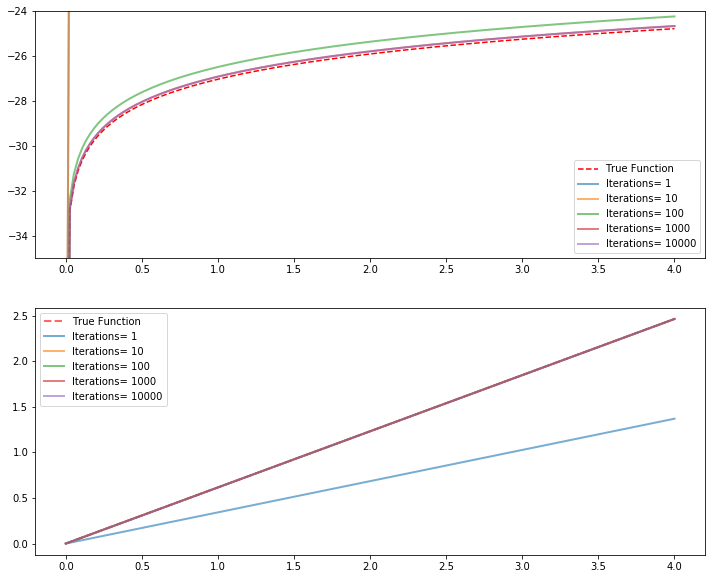

In [20]:
fig, axes = plt.subplots(2,1,figsize=(12,10))
vfi=VFI(h,r,Gamma)
axes[0].plot(vfi.grid,v_star(vfi.grid),'r--',label='True Function')
axes[1].plot(vfi.grid, σ_star(vfi.grid), 'r--', lw=2, alpha=0.6, label='True Function')

N=[1,10,100,1000,10000]

for n in N:
    vfi=VFI(h,r,Gamma)
    v_solution,c_solution,error=vfi.solve_model(tol=1e-20, max_iter=n)  #so that we do n iterations
    
    axes[0].plot(vfi.grid, v_solution, lw=2, alpha=0.6,label=f'Iterations= {n}') 
    axes[1].plot(vfi.grid, c_solution, lw=2, alpha=0.6,label=f'Iterations= {n}')
    print(f'error at {n} iteration(s) is {error}')

axes[0].legend()
axes[1].legend()
axes[0].set_ylim(-35,-24)
plt.show()

Now we find convergence at a different variance, say 0.5. Again, difference between approximation and true function 
is $10^{-4}$ at 229 iterations. As it is obvious from formula, true functions do not depend on sigma. Plots are not distinguishable.


Converged in 227 iterations.
steady state in 0.1 is  4.437694101250946e-06

Converged in 227 iterations.
steady state in 0.5 is  4.437694101250946e-06


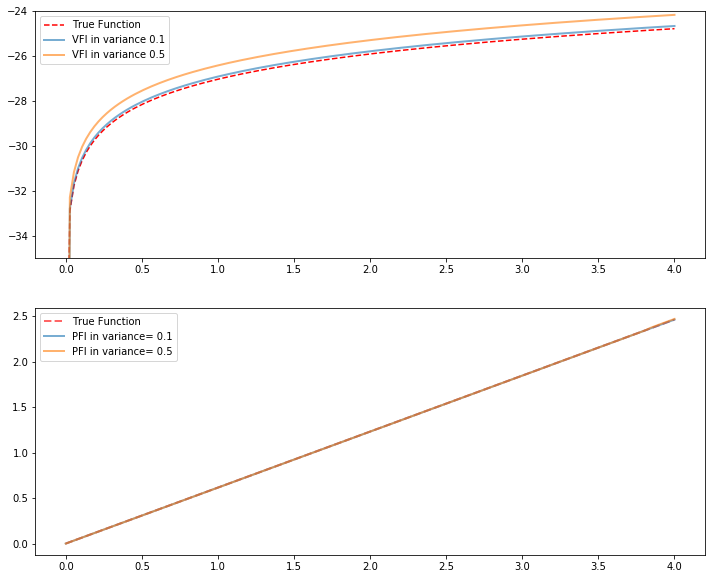

In [5]:
def steady_state(y_star,grid): #min (k'-k)
    dist=y_star - grid
    dist=np.abs(dist) #otherwise negative numbers will be recognized as min
    dist=-1*dist #because we want to use maximization
    l=np.argmax(dist) #where is distance minimized?(-distance maximized)
    kss=y_star[l]
    return kss
    
def _variances():
    fig, axes = plt.subplots(2,1,figsize=(12,10))
    vfi=VFI(h,r,Gamma)
    axes[0].plot(vfi.grid,v_star(vfi.grid),'r--',label='True Function')
    axes[1].plot(vfi.grid, σ_star(vfi.grid), 'r--', lw=2, alpha=0.6, label='True Function')

    variances=[0.1,0.5]
    kss= np.zeros(2)
    
    np.empty(2)
    i=0
    
    for s in variances:
        vfi=VFI(h,r,Gamma,s=s)
        v_solution,c_solution,error=vfi.solve_model()  

        axes[0].plot(vfi.grid, v_solution, lw=2, alpha=0.6,label=f'VFI in variance {s}') 
        axes[1].plot(vfi.grid, c_solution, lw=2, alpha=0.6,label=f'PFI in variance= {s}')
        
        kss[i]=steady_state(c_solution,vfi.grid)
        print(f'steady state in {s} is ',kss[i])
        i+=1

    
    
    axes[0].legend()
    axes[1].legend()
    axes[0].set_ylim(-35,-24)
    plt.show()

    
_variances()


Note that the variance always affects VFI, in this case PFI is unaffected.

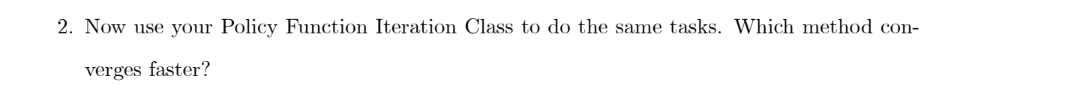

In [1]:
!pip install interpolation
!pip install quantecon

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import njit, prange
from quantecon.optimize.scalar_maximization import brent_max
import time

In [3]:
#This class contains all the parametarizations and grids.
class OptimalGrowthModel:

    def __init__(self,
                 h,                # Production function (can have other implementations too)
                 r,                # return function
                 β=0.96,           # Discount factor
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=150,
                 shock_size=250):
        np.random.seed(10)
        self.β, self.μ, self.s = β, μ, s
        self.h, self.r = h, r

        self.grid = np.linspace(1e-5, grid_max, grid_size)         # Set up grid: 2 dimensional because we have a,s
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks

In [4]:
def σ_star(y, α=0.4, β=0.96):
    """
    True optimal policy
    """
    return (1 - α * β) * y

def v_star(y, α=0.4, β=0.96, μ=0):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [5]:
α = 0.4  # Production function parameter

@njit
def h(y,u):
    """
    Cobb-Douglas production function
    """
    return (y-u)**α

@njit
def r(y,u,sigma=0.1):
    return np.log(u)

@njit
def Gamma(y):
    return y


In [6]:
def operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Bellman operator, as well as
    a function that computes greedy policies.

    Here og is an instance of OptimalGrowthModel.
    """

    h, r, β = og.h, og.r, og.β
    grid, shocks = og.grid, og.shocks

    @njit
    def objective(u, v, y):
        """
        The right hand side of the Bellman equation
        """
        # First turn v into a function via interpolation
        v_func = lambda x: interp(grid, v, x)
        return r(y,u) + β * np.mean(v_func(h(y,u) * shocks))

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """
        v_new = np.empty_like(v)
        for i in prange(len(grid)):
            y = grid[i]
            # Solve for optimal v at y
            v_max = brent_max(objective, 1e-10, Gamma(y), args=(v, y))[1]
            v_new[i] = v_max
        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        σ = np.empty_like(v)
        for i in range(len(grid)):
            y = grid[i]
            # Solve for optimal c at y
            c_max = brent_max(objective, 1e-10, y, args=(v, y))[0]
            σ[i] = c_max
        return σ

    return T, get_greedy

In [7]:
class Solver:
    def __init__(self,og):
        self.og=og


    def solve_model(self,
                    use_parallel=True,
                    tol=1e-4,
                    max_iter=1000,
                    verbose=True,
                    print_skip=25):
        og=self.og
        T, get_greedy= operator_factory(og, parallel_flag=use_parallel) 

        # Set up loop
        g_0 = 0.9*(og.grid)  # Initial condition
        v  = r(0,g_0)      # Initial v corresponding to g_0
        
        i = 0
        error = tol + 1

        while i < max_iter and error > tol:
            v_new = T(v)
            c_star= get_greedy(v)
            error = np.max(np.abs(c_star - g_0))
            i += 1
           # if verbose and i % print_skip == 0:
            #    print(f"Error at iteration {i} is {error}.")
            v = v_new
            g_0 = c_star
            

        #if i == max_iter:
         #   print("Failed to converge!")

        if verbose and i < max_iter:
            print(f"\nConverged in {i} iterations.")

        return v_new,T,get_greedy,error
    
    def result(self):
        v_solution,T,get_greedy,error = self.solve_model()
        
        
        plt.plot(self.og.grid, v_solution, lw=2, alpha=0.6,
                label='Approximate value function')
        plt.legend()
        plt.show()
        
        plt.plot(self.og.grid, get_greedy(v_solution), lw=2, alpha=0.6,
                label='Approximate Policy function')
        
        plt.legend()
        plt.show()
        
        


Converged in 11 iterations.


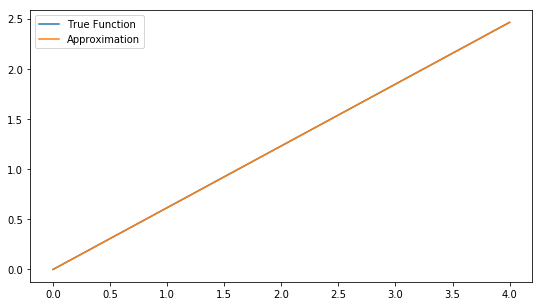

elapsed time: 4.346240282058716


In [8]:
start = time.time()

og = OptimalGrowthModel(h,r)
solve=Solver(og)
v_sol,T,get_greedy,error=solve.solve_model()
fig,ax=plt.subplots(figsize=(9,5))
ax.plot(og.grid,σ_star(og.grid),label='True Function')
ax.plot(og.grid,get_greedy(v_sol),label="Approximation")
# ax.set_ylim(-34,-24)
ax.legend()
plt.show()

end = time.time()
 
print('elapsed time:',end - start)

Although we changed our algorithm, it seems that PFI is much faster than VFI because the number of iterations are quite low.

error at 1 iterations is 0.7102624455594255
error at 10 iterations is 0.00014098597517975264
error at 100 iterations is 5.3773447916682926e-08
error at 1000 iterations is 5.192582097635068e-08
error at 10000 iterations is 9.671602096972265e-08


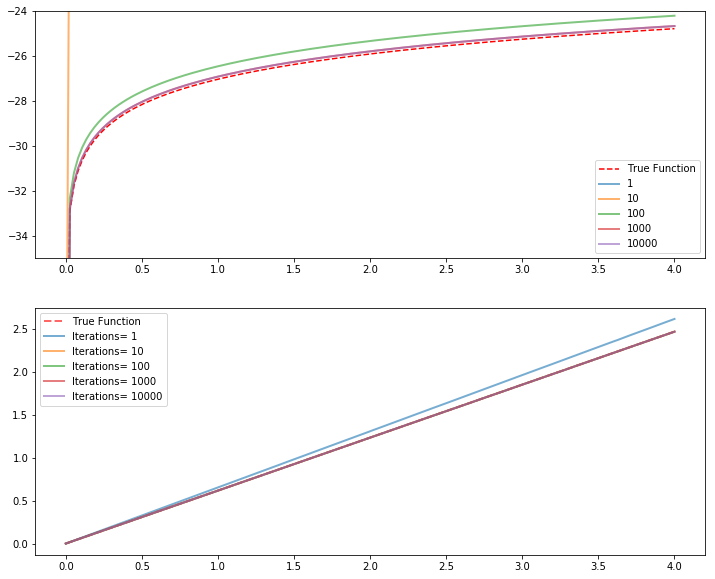

In [9]:
fig, axes = plt.subplots(2,1,figsize=(12,10))
axes[0].plot(og.grid,v_star(og.grid),'r--',label='True Function')
axes[1].plot(og.grid, σ_star(og.grid), 'r--', lw=2, alpha=0.6, label='True Function')

N=[1,10,100,1000,10000]
for n in N:
    v_solution, T, get_greedy,error=  solve.solve_model(max_iter=n,tol=1e-100)       
    axes[0].plot(og.grid, v_solution, lw=2, alpha=0.6,label=f'{n}') 
    axes[1].plot(og.grid, get_greedy(v_solution), lw=2, alpha=0.6,label=f'Iterations= {n}')
    print(f'error at {n} iterations is {error}')

axes[0].legend()
axes[1].legend()
axes[0].set_ylim(-35,-24)
plt.show()

Now we find convergence at a different variance, say 0.5. Again, difference between approximation and true function 
is $10^{-4}$ at 11 iterations. As it is obvious from formula, true functions do not depend on sigma.


Converged in 11 iterations.


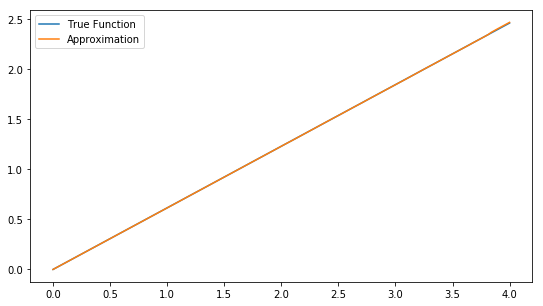

In [10]:
og = OptimalGrowthModel(h,r,s=0.5)
solve=Solver(og)
v_sol,T,get_greedy,error=solve.solve_model()
fig,ax=plt.subplots(figsize=(9,5))
ax.plot(og.grid,σ_star(og.grid),label='True Function')
ax.plot(og.grid,get_greedy(v_sol),label="Approximation")
# ax.set_ylim(-34,-24)
ax.legend()
plt.show()

Again we see that the variance of the shock does not affect the policy function.

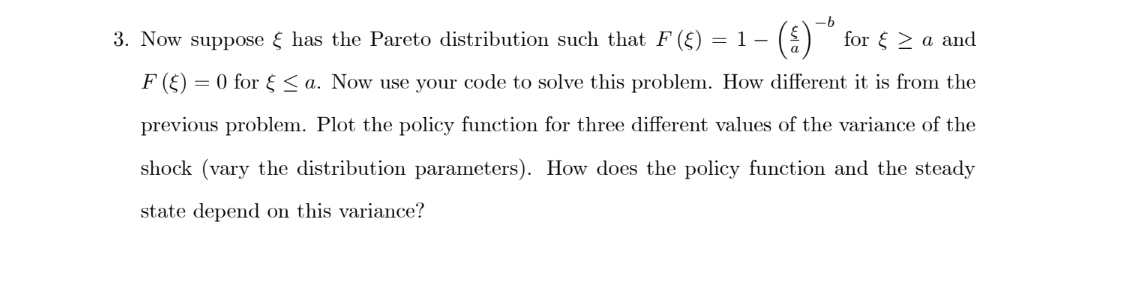

run the VIF class first

In [32]:
from scipy.stats import pareto

In [33]:
class Pareto(VFI):

     def __init__(self,
                 h,  # Production function (can have other implementations too)
                 r,# return function
                 Gamma,
                 β=0.96,           # Discount factor
                 μ=1,
                 s=0.1,
                 grid_max=4,
                 grid_size=150,
                 shock_size=250):
        np.random.seed(10)
        self.β, self.μ, self.s = β, μ, s
        self.h, self.r = h, r
        self.grid_size=grid_size
        
        self.grid = np.linspace(1e-5, grid_max, grid_size) 
        self.shocks =  pareto.rvs(s, μ, size=shock_size) # Store shocks


Failed to converge!
error at 1 iteration(s) is 22.973252859085775
Failed to converge!
error at 10 iteration(s) is 0.31491809955455885
Failed to converge!
error at 100 iteration(s) is 0.00797635234463101

Converged in 321 iterations.
error at 1000 iteration(s) is 9.632673858561702e-07

Converged in 321 iterations.
error at 10000 iteration(s) is 9.632673858561702e-07


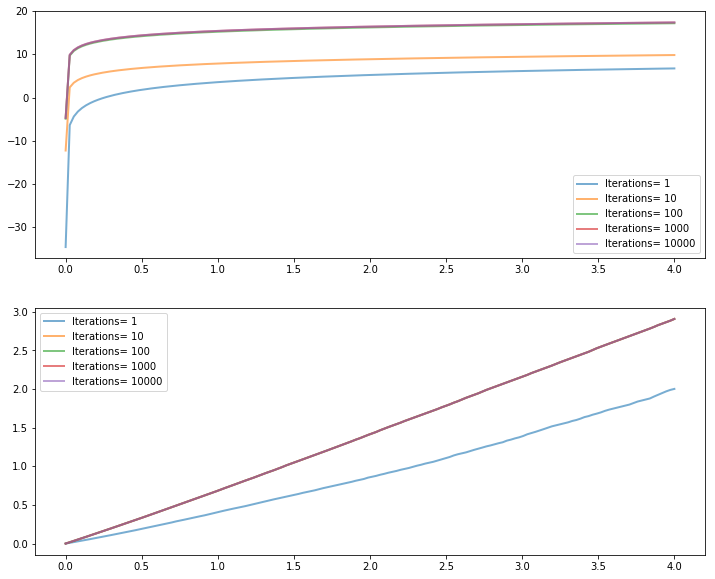

In [34]:
fig, axes = plt.subplots(2,1,figsize=(12,10))

N=[1,10,100,1000] #converges before 10000 iterations!
for n in N:
    vfi=Pareto(h,r,Gamma,s=1)
    v_solution,c_solution,error=vfi.solve_model(tol=1e-6, max_iter=n)  #so that we do n iterations
    
    axes[0].plot(vfi.grid, v_solution, lw=2, alpha=0.6,label=f'Iterations= {n}') 
    axes[1].plot(vfi.grid, c_solution, lw=2, alpha=0.6,label=f'Iterations= {n}')
    print(f'error at {n} iteration(s) is {error}')

axes[0].legend()
axes[1].legend()

plt.show()


Converged in 208 iterations.

Converged in 200 iterations.

Converged in 192 iterations.


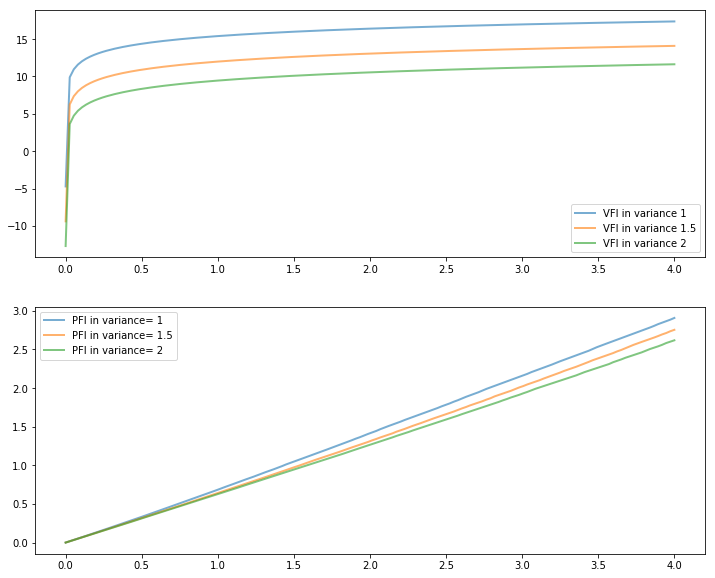

In [35]:
def _variances():
    fig, axes = plt.subplots(2,1,figsize=(12,10))

# changing shock parameters.
    
    parameters=[1,1.5,2]

    for s in parameters:
        vfi=Pareto(h,r,Gamma,s=s)
        v_solution,c_solution,error=vfi.solve_model()  

        axes[0].plot(vfi.grid, v_solution, lw=2, alpha=0.6,label=f'VFI in variance {s}') 
        axes[1].plot(vfi.grid, c_solution, lw=2, alpha=0.6,label=f'PFI in variance= {s}')
        

    axes[0].legend()
    axes[1].legend()
    
    plt.show()



_variances()

As we see, in contrast to the part 3.1, changing the parameter of the pareto distribution affects both PFI and VFI.